# EmployeePayHistory

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [3]:
sql_query_employeepayhistory = "SELECT * FROM EmployeePayHistory"
employeepayhistory_df = read_data_return_df(sql_query_employeepayhistory, engine)

employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_sk,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,EMPLOYEEPAYHISTORY_datetime_added
0,1,508,2009-01-14,125.5000,2,2024-05-26 17:15:07.033
1,2,659,2008-01-31,63.4615,2,2024-05-26 17:15:07.033
2,3,890,2007-11-11,43.2692,2,2024-05-26 17:15:07.033
3,4,660,2007-12-05,8.6200,2,2024-05-26 17:15:07.033
4,5,660,2010-05-31,23.7200,2,2024-05-26 17:15:07.033


In [4]:
sql_query_businessentity = "SELECT * FROM BusinessEntity"
businessentity_df = read_data_return_df(sql_query_businessentity, engine)

businessentity_df.head()

,BUSINESSENTITY_sk,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,BUSINESSENTITY_CONTACTTYPE_Name,BUSINESSENTITY_datetime_added
0,1,NaN,NaN,1.0,Accounting Manager,2024-05-26 17:14:05.540
1,2,1510.0,1509.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
2,3,1518.0,1517.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
3,4,1522.0,1521.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
4,5,1528.0,1527.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540


In [5]:
sql_query_employee = "SELECT EMPLOYEE_EMPLOYEE_EmployeeID, EMPLOYEE_EMPLOYEE_ManagerID, EMPLOYEE_EMPLOYEE_DeptID, EMPLOYEE_EMPLOYEE_State, EMPLOYEE_EMPLOYEE_Start_Date, EMPLOYEE_EMPLOYEE_OrganizationLevel, EMPLOYEE_EMPLOYEE_BirthDate, EMPLOYEE_EMPLOYEE_SickLeaveHours FROM Employee"
employee_df = read_data_return_df(sql_query_employee, engine)

employee_df.head()

,EMPLOYEE_EMPLOYEE_EmployeeID,EMPLOYEE_EMPLOYEE_ManagerID,EMPLOYEE_EMPLOYEE_DeptID,EMPLOYEE_EMPLOYEE_State,EMPLOYEE_EMPLOYEE_Start_Date,EMPLOYEE_EMPLOYEE_OrganizationLevel,EMPLOYEE_EMPLOYEE_BirthDate,EMPLOYEE_EMPLOYEE_SickLeaveHours
0,1,NaN,NaN,None,None,NaN,1969-01-29,69.0
1,2,NaN,NaN,None,None,1.0,1971-08-01,20.0
2,3,NaN,NaN,None,None,2.0,1974-11-12,21.0
3,4,NaN,NaN,None,None,3.0,1974-12-23,80.0
4,5,NaN,NaN,None,None,3.0,1952-09-27,22.0


## Data Cleaning

In [6]:
# combining the dataframes
combined_df = pd.merge(employeepayhistory_df ,businessentity_df, left_on='EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', right_on='BUSINESSENTITY_sk', suffixes=('_eph', '_b'))

combined_df = pd.merge(combined_df, employee_df, left_on='BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID', right_on='EMPLOYEE_EMPLOYEE_EmployeeID', suffixes=('', '_e'), how='outer')

In [7]:
# dropping unnecessary columns
columns_to_keep = ['EMPLOYEE_EMPLOYEE_EmployeeID', 'EMPLOYEE_EMPLOYEE_ManagerID', 'EMPLOYEE_EMPLOYEE_DeptID', 'EMPLOYEE_EMPLOYEE_State', 'EMPLOYEE_EMPLOYEE_BirthDate', 'EMPLOYEE_EMPLOYEE_Start_Date', 'EMPLOYEE_EMPLOYEE_OrganizationLevel', 'EMPLOYEE_EMPLOYEE_SickLeaveHours', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency', 'BUSINESSENTITY_CONTACTTYPE_ContactTypeID', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate']

combined_df = combined_df[columns_to_keep]

In [8]:
# converting EMPLOYEE_EMPLOYEE_State
combined_df['EMPLOYEE_EMPLOYEE_State'] = combined_df['EMPLOYEE_EMPLOYEE_State'].astype('category').cat.codes

# Convert the datetime column to number of days since Unix epoch
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = pd.to_datetime(combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'], errors='coerce')
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_BirthDate'], errors='coerce')
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_Start_Date'], errors='coerce')

# Convert the datetime objects to number of days since Unix epoch
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = (combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = (combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = (combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

In [9]:
# fixing null values
drop_columns(combined_df)

# dropping all rows where EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate is null/-1
combined_df = combined_df[combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'] != -1]

In [10]:
combined_df.info()

,EMPLOYEE_EMPLOYEE_EmployeeID,EMPLOYEE_EMPLOYEE_ManagerID,EMPLOYEE_EMPLOYEE_DeptID,EMPLOYEE_EMPLOYEE_State,EMPLOYEE_EMPLOYEE_BirthDate,EMPLOYEE_EMPLOYEE_Start_Date,EMPLOYEE_EMPLOYEE_OrganizationLevel,EMPLOYEE_EMPLOYEE_SickLeaveHours,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate
402,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,63.4615,2.0,15.0,13909.0
403,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,8.6200,2.0,15.0,13852.0
404,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,23.7200,2.0,15.0,14760.0
405,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,29.8462,2.0,15.0,15323.0
406,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,32.6923,2.0,11.0,13902.0
...,...,...,...,...,...,...,...,...,...,...,...,...
740,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,9.5000,1.0,-1.0,14265.0
741,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,14.0000,1.0,-1.0,14222.0
742,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,10.0000,1.0,-1.0,14259.0
743,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1.0,15.0000,1.0,-1.0,14244.0


## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [11]:
# splitting the data
X = combined_df.drop(columns=['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'])
y = combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [12]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [15]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 70.70585121241156
R2 Score: 0.3078934297922168


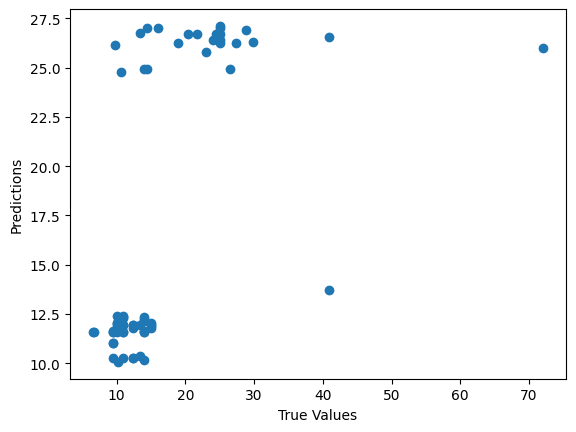

In [16]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [17]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,27.023967,-12.600867,12.600867,158.781843
541,20.4327,26.704141,-6.271441,6.271441,39.330972
615,11.0000,12.358168,-1.358168,1.358168,1.844621
411,24.0000,26.390728,-2.390728,2.390728,5.715580
513,14.0000,11.608860,2.391140,2.391140,5.717552
...,...,...,...,...,...
649,16.0000,27.019043,-11.019043,11.019043,121.419300
467,11.0000,11.603232,-0.603232,0.603232,0.363889
713,13.9423,24.925010,-10.982710,10.982710,120.619922
684,11.0000,11.939941,-0.939941,0.939941,0.883488


### Decision Tree Regressor

In [18]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [19]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [20]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 63.74267275251074
R2 Score: 0.3760527331453275


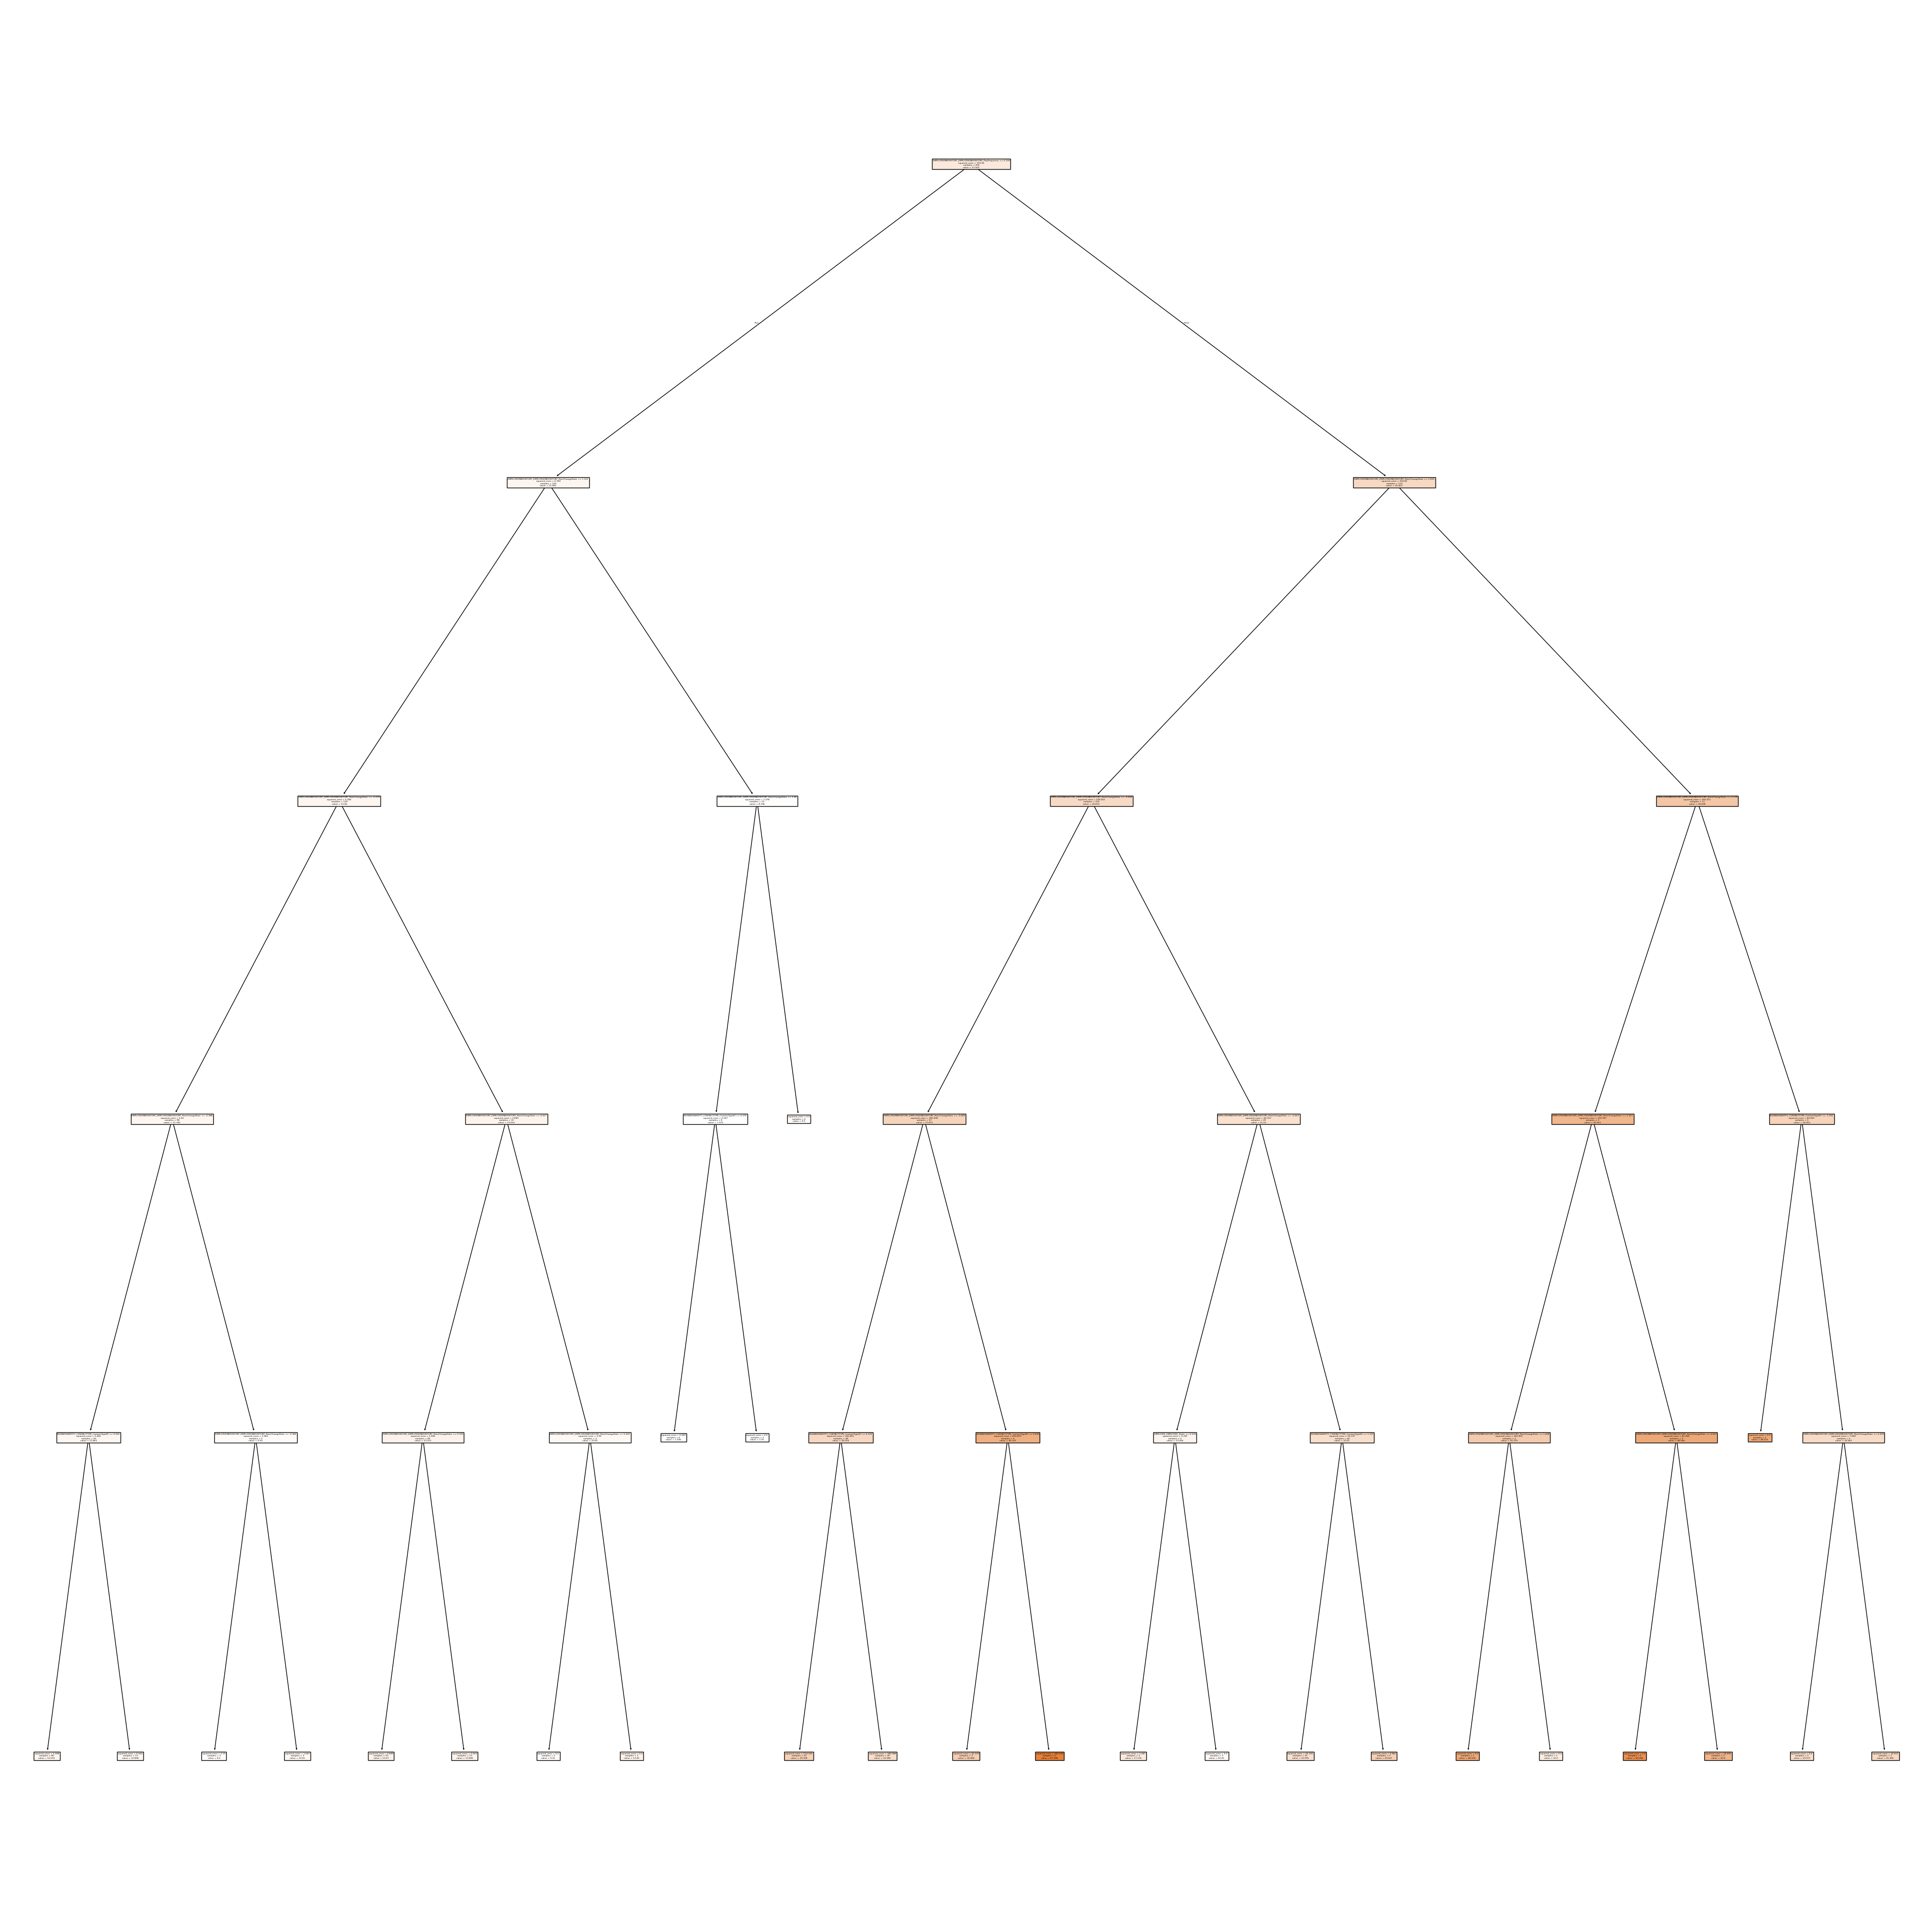

In [21]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [22]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,23.283535,-8.860435,8.860435,78.507302
541,20.4327,23.283535,-2.850835,2.850835,8.127258
615,11.0000,10.807692,0.192308,0.192308,0.036982
411,24.0000,29.328445,-5.328445,5.328445,28.392331
513,14.0000,12.032500,1.967500,1.967500,3.871056
...,...,...,...,...,...
649,16.0000,23.283535,-7.283535,7.283535,53.049876
467,11.0000,12.032500,-1.032500,1.032500,1.066056
713,13.9423,30.689100,-16.746800,16.746800,280.455310
684,11.0000,12.032500,-1.032500,1.032500,1.066056


### Pytorch Neural Network

In [23]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [24]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 2993.46875
Epoch 100, Loss: 110.29129028320312
Epoch 200, Loss: 252.6887969970703
Epoch 300, Loss: 172.71246337890625
Epoch 400, Loss: 91.70840454101562
Epoch 500, Loss: 44.802833557128906
Epoch 600, Loss: 33.96504211425781
Epoch 700, Loss: 120.94542694091797
Epoch 800, Loss: 302.5439147949219
Epoch 900, Loss: 140.6578369140625


#### Calculating the metrics and visualizing the results

In [27]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 96.8149185180664
Average R2 Score: -0.15601646900177002


In [28]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,14.423100,18.817890,-4.394790,4.394790,19.314177
1,20.432699,18.722261,1.710438,1.710438,2.925597
2,11.000000,18.617001,-7.617001,7.617001,58.018700
3,24.000000,18.233597,5.766403,5.766403,33.251408
4,14.000000,18.403614,-4.403614,4.403614,19.391817
...,...,...,...,...,...
60,16.000000,18.833624,-2.833624,2.833624,8.029425
61,11.000000,18.421597,-7.421597,7.421597,55.080093
62,13.942300,18.446791,-4.504491,4.504491,20.290438
63,11.000000,18.463270,-7.463270,7.463270,55.700401
